# Previsão de Vendas

A Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência.
 
As vendas da loja são influenciadas por muitos fatores, incluindo promoções, concorrência, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode variar bastante.

# 0.0 IMPORTS

In [118]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

## 0.1 Helper Functions

## 0.2 Loading Data

In [59]:
cwd = os.getcwd()
df_sales_raw = pd.read_csv(cwd+"/dados/train.csv", low_memory=False)
df_store_raw = pd.read_csv(cwd+"/dados/store.csv", low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 - PASSO 01 - DESCRIÇÃO DOS DADOS

In [60]:
# Criando copia de segurança dos dados
df1 = df_raw.copy()

## 1.1 Rename Columns

In [61]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
               'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
               'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, old_columns))

# Renomeando as colunas
df1.columns = new_columns

## 1.2 Data Dimessions

In [62]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


## 1.3 Data Types

In [63]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [64]:
# Convertendo Data para o tipo datetime
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA's

In [65]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [66]:
# Temos 6 colunas com valores nulos que devem ser analisados e tratados de acordo com cada caso.

# competition_distance 
# competition_open_since_month 
# competition_open_since_year  
# promo2_since_week            
# promo2_since_year            
# promo_interval 

df1['competition_distance'].max()

75860.0

In [67]:
# competition_distance = distance in meters to the nearest competitor store
# Assumindo que se esta NA, é porque não tem um competidor proximo, 
# então vamos preencher com um valor acima do maximo encotrando no dataset por meio de uma função lambda
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)



# competition_open_since_month/competition_open_since_year  = gives the approximate year and month of the time the nearest competitor was opened
# Nesse caso podemos pensar em duas possibilidades: 
# 1) Não tem competidor, então não tem data de abertura
# 2) Tem competidor, mas não temos a data de abertura
# Nesse caso podemos supor que se está NA, então vamos preencher a comptetition_open_since_month com a data da venda (date))
# Isso por que em um cenario hipotetico, se não tem competidor, então não tem data de abertura, então vamos supor que a data de abertura é a data da venda
# Pois se em algum momento futuro, tivermos um competidor, então teremos uma forma de comparar o efeito de um novo competidor nas vendas
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


# promo2_since_week = describes the year and calendar week when the store started participating in Promo2
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year = describes the year and calendar week when the store started participating in Promo2
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval  = describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
             

In [68]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [69]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## 1.7 Descriptive Statistical

In [70]:

num_atributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])
cat_atributes = df1.select_dtypes(exclude=['int64', 'float64', 'int32' , 'datetime64[ns]'])


In [71]:
# Central Tendency - Mean, Median
ct_mean = pd.DataFrame(num_atributes.apply(np.mean)).T
ct_mediam = pd.DataFrame(num_atributes.apply(np.median)).T


# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d_std = pd.DataFrame(num_atributes.apply(np.std)).T
d_min = pd.DataFrame(num_atributes.apply(np.min)).T
d_max = pd.DataFrame(num_atributes.apply(np.max)).T
d_range = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min())).T
d_skew = pd.DataFrame(num_atributes.apply(lambda x: x.skew())).T
d_kurtosis = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([d_min, d_max, d_range, d_std, ct_mean, ct_mediam, d_skew, d_kurtosis]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'std', 'mean', 'median', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,std,mean,median,skew,kurtosis
0,store,1.0,1115.0,1114.0,321.908493,558.429727,558.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,1.997390,3.998341,4.0,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,3849.924283,5773.818972,5744.0,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,464.411506,633.145946,609.0,1.598650,7.091773
4,open,0.0,1.0,1.0,0.375539,0.830107,1.0,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.485758,0.381515,0.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.383056,0.178647,0.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,12547.646829,5935.442677,2330.0,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,3.311085,6.786849,7.0,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,5.515591,2010.324840,2012.0,-7.235657,124.071304


In [72]:
# Categorical Atributes
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

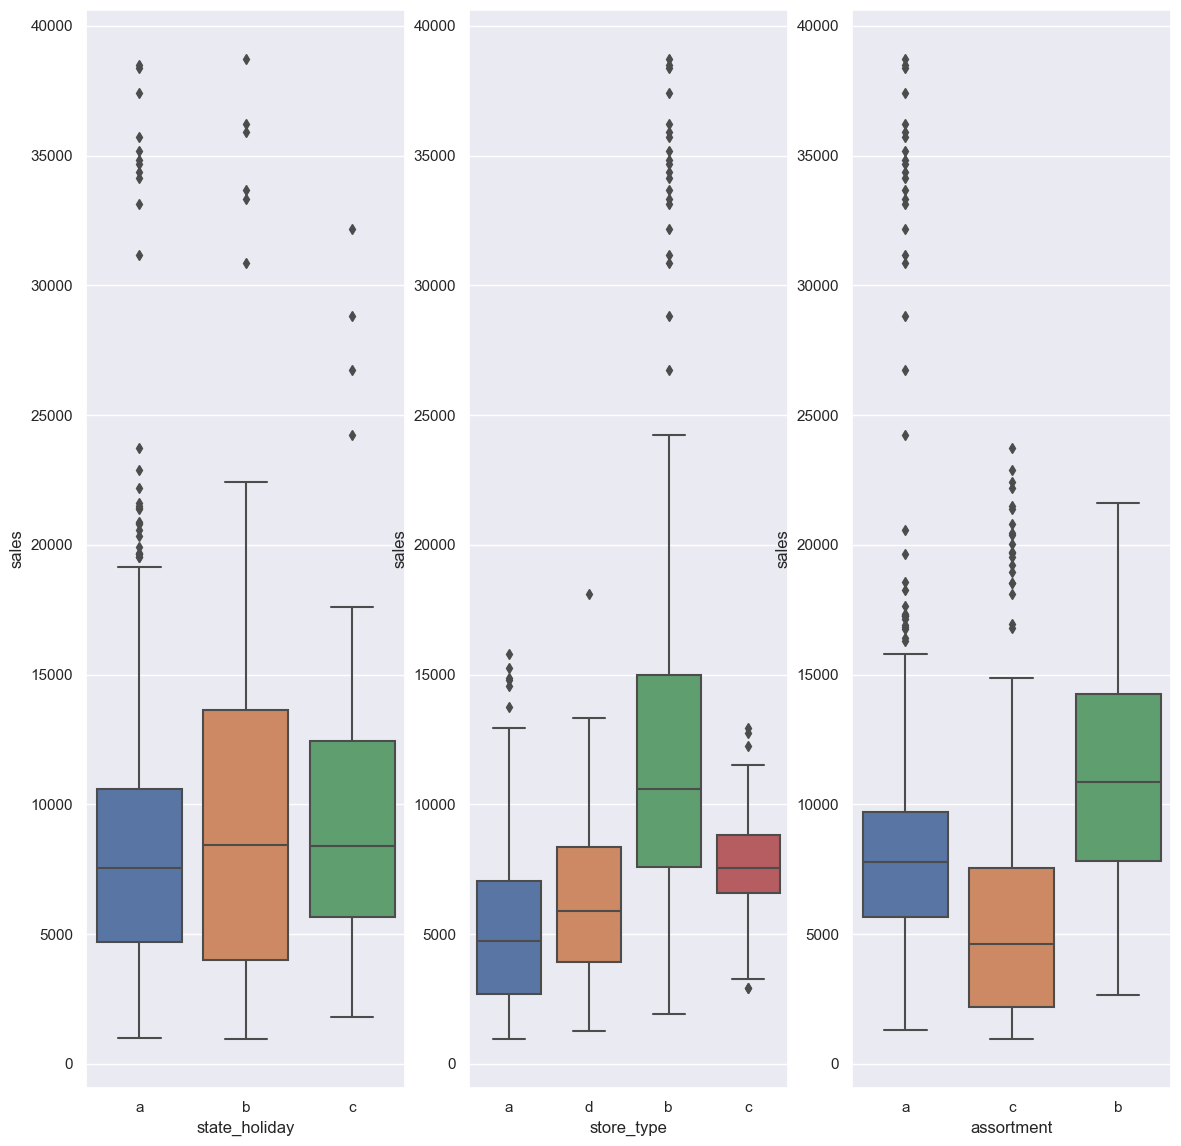

In [73]:
# Categorical Atributes
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)
sns.set(rc={'figure.figsize':(14,14)})

# 2.0 - PASSO 02 - FEATURE ENGINEERING

In [74]:
# Criando uma cópia do dataset
df2 = df1.copy()

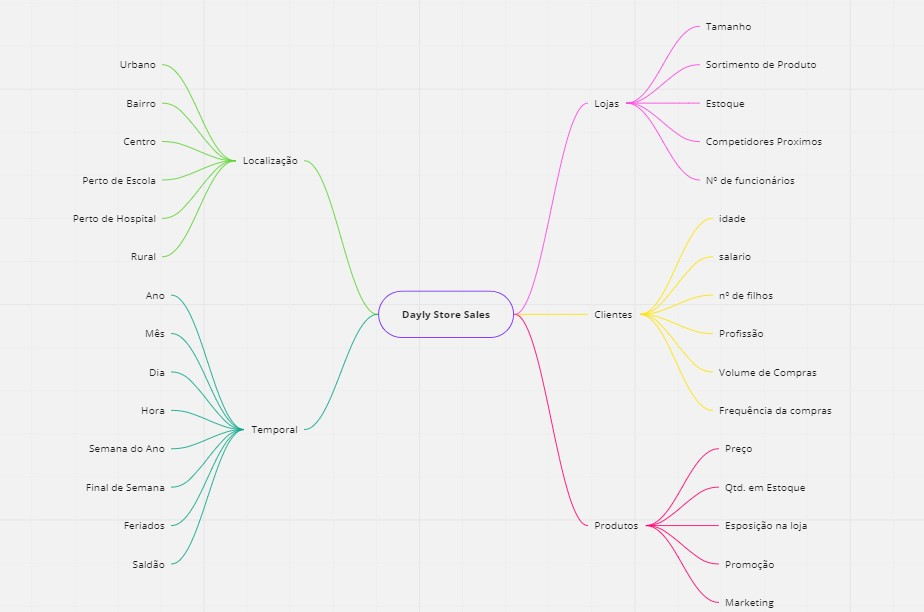

In [75]:
Image(cwd+'/img/mapa_mental_hipoteses.jpg')

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveria vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas sem competidores proximos deveriam vender mais.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas(Descontos maiores), deveriam vender mais.




### 2.1.2 Hipóteses Tempo

**1.** Lojas abertas durante feriados deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante feriados escolares.

**7.** Lojas deveriam vender mais durante o inverno.





### 2.1 Lista Final de Hipóteses(Prioridades)

Inicialmente podemos dar prioridade as hipóteses que podemos validar com dados que já temos.
Em um segundo momento se percebemos que outras hipóteses são relevantes e precisarmos usa-las para melhorar a performance do modelo, ai então trabalhamos com essas outras possibilidades.

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativa por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção ativa deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante feriados deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante feriados escolares.

**13.** Lojas deveriam vender mais durante o inverno.

### 2.2 Feature Engineering

In [76]:
# Derivando novas variaveis

# Derivando variaveis a partir da coluna date
# 1) year
df2['year'] = df2['date'].dt.year
# 2) month
df2['month'] = df2['date'].dt.month
# 3) day
df2['day'] = df2['date'].dt.day
# 4) week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# 5) year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Derivando variaveis a partir da coluna 
# 1) competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# 2) promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')





# 3.0 - PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [77]:
# Copia de segurança dos dados
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [78]:
# Filtrando as linhas diminui o tamanho do dataset como um todo, logo melhorando a performance do dataset

# Nesse caso vamos observamos que as lojas que não tem venda não contribuem em nada para a solução do problema, logo
# selecionamos apenas as linhas cuja a coluna open seja diferente de Zero, pois isso indica que a loja está aberta.
# Também selecionamos apenas lojas cujas vendas sejam maiores que Zero.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [79]:
# Excluindo as colunas que não serão necessarias para o estudo!
# costumers = pois essa coluna nos diz quantos clientes havia na loja no dia da venda! Baseado em nosso contexto 
# pois no momento da predição não teriamos essa informação, teriamos que fazer uma previsão separada para sabermos
# quantas pessoas vão ter em cada loja nas proximas 6 semanas, o que nesse primeiro momento não parece viavel
 
# open = Nesse momento não é mais necessaria, pois acima filtramos somente as lojas abertas, logo e uma coluna que não
# acrescenta nenhuma informação importante.

# promo_interval e month_map = colunas auxiliares ou que já derivamos outras variaveis 

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [80]:
df4 = df3.copy()

num_atributes = df4.select_dtypes(include=['int64', 'float64', 'int32'])
cat_atributes = df4.select_dtypes(exclude=['int64', 'float64', 'int32' , 'datetime64[ns]'])


## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

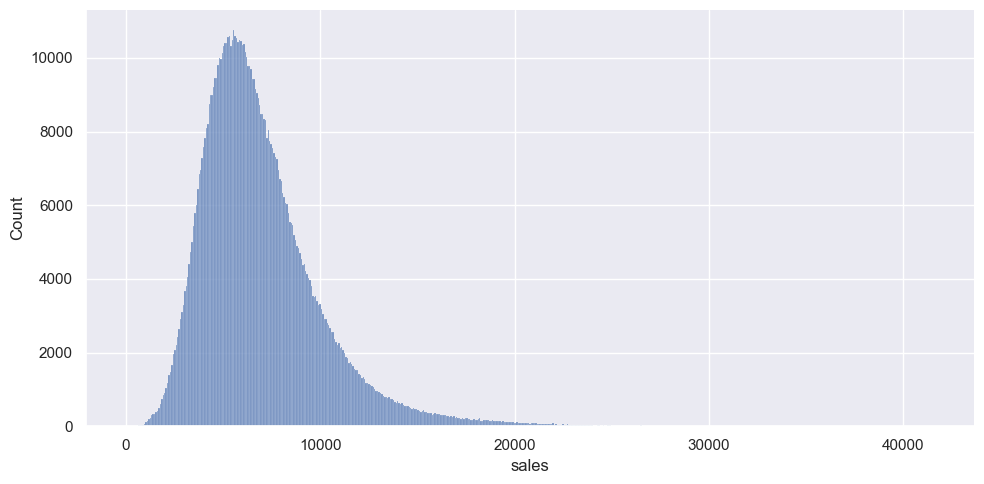

In [81]:
sns.displot(df4['sales'], aspect = 2);

### 4.1.2 Variáveis Númericas

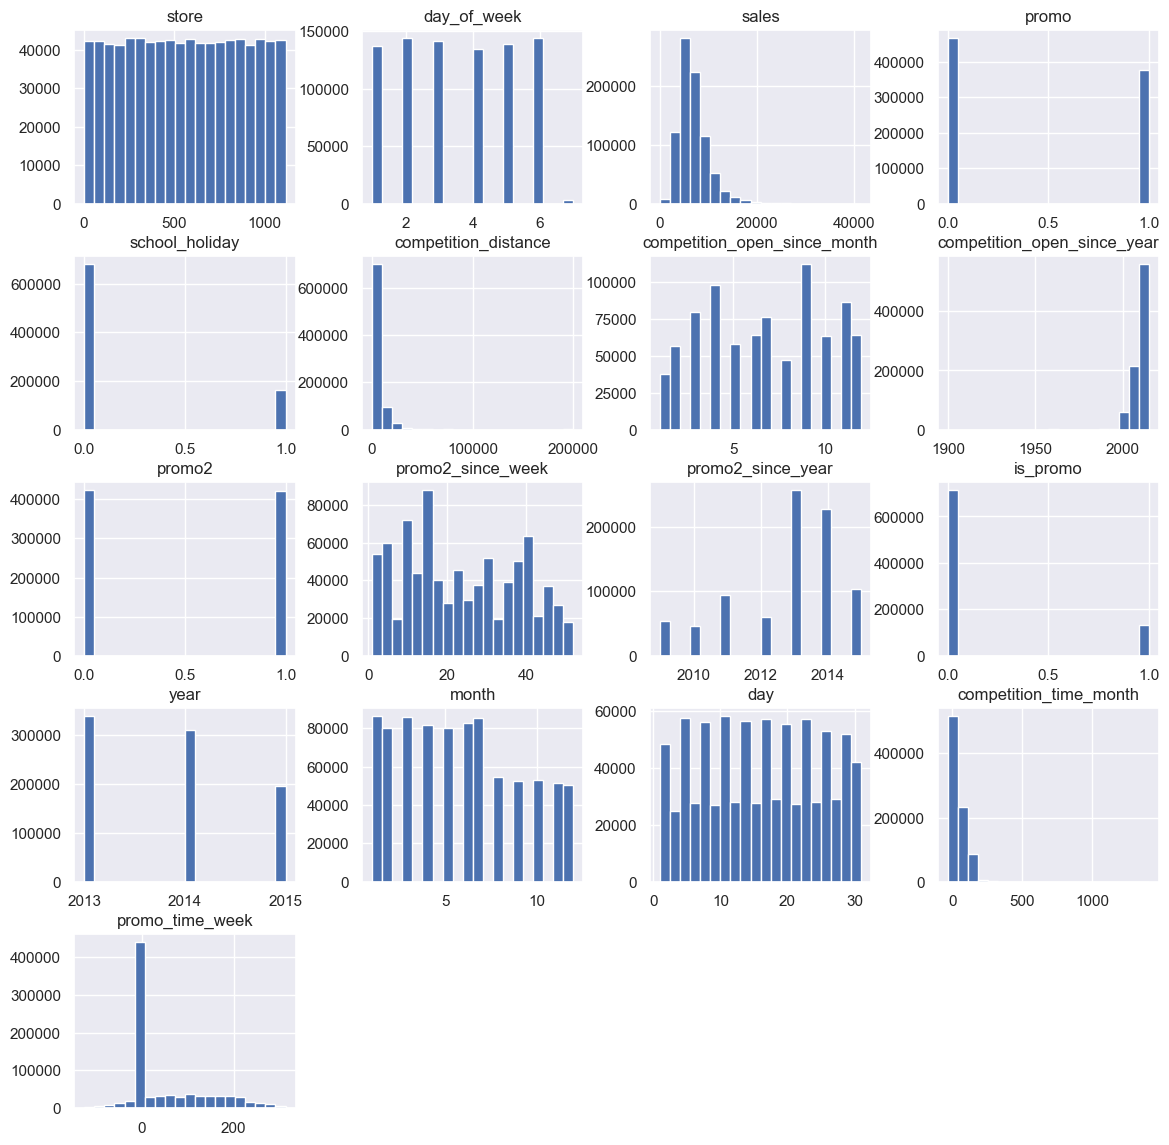

In [82]:
num_atributes.hist(bins=20);

 No Competition_distance podemos notar que a maioria dos competidores estão muito proximos.

No Competition_open_since_month podemos notar uma variação muito grande dos dados, com pico ocorrendo em torno
8 meses de competição.



### 4.1.3 Variáveis Categoricas

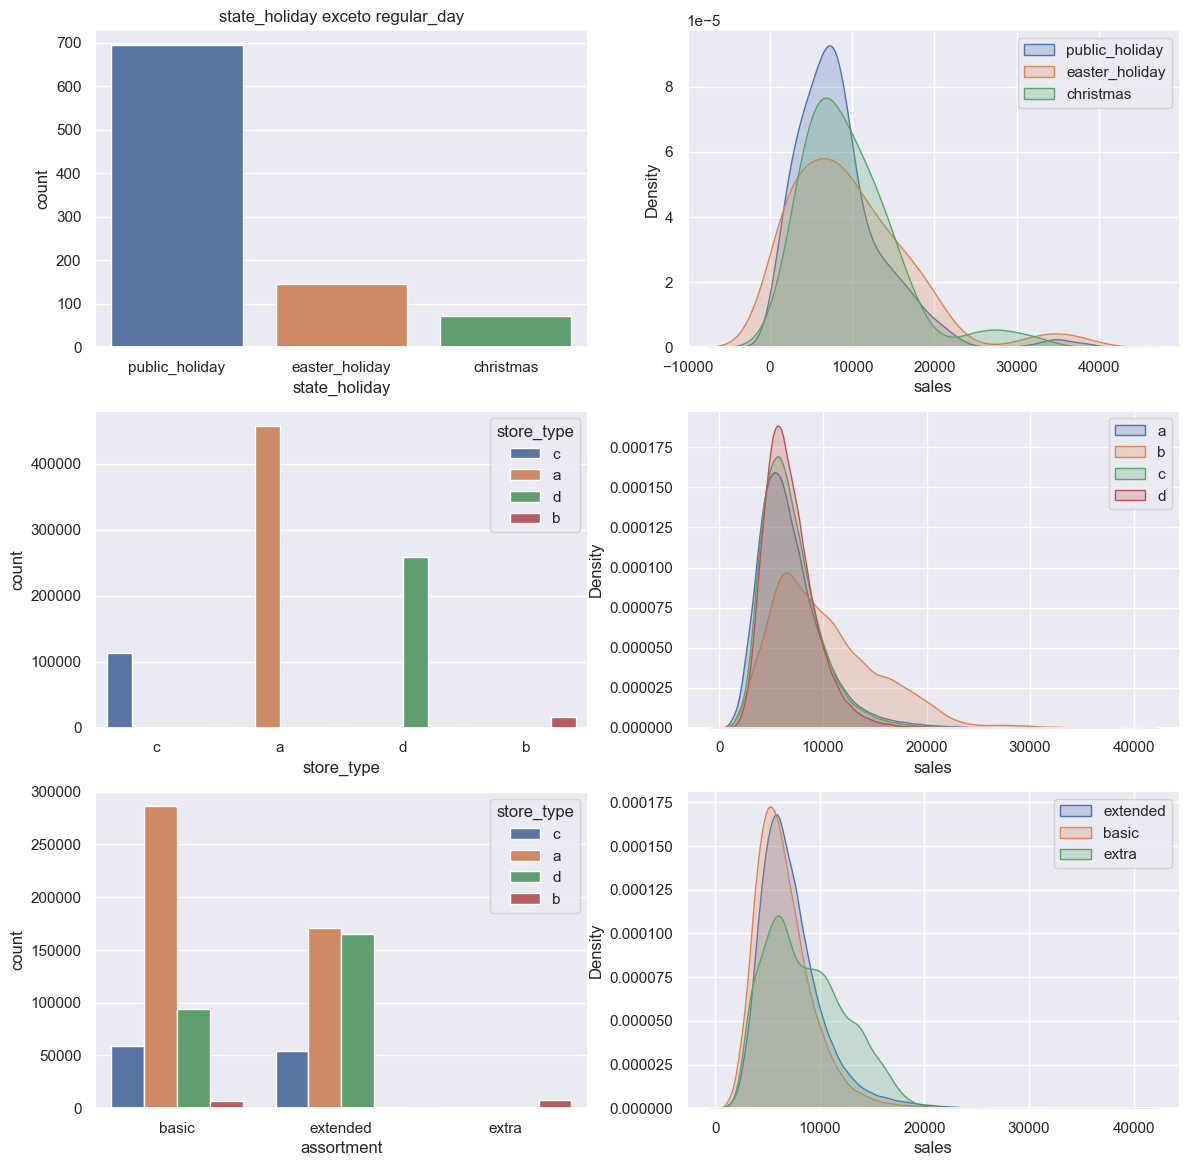

In [83]:

# state_holiday
state_holiday = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1).set_title('state_holiday exceto regular_day');
sns.countplot(data=(state_holiday), x='state_holiday');

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday', fill=True );
sns.kdeplot( df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',  fill=True );
sns.kdeplot( df4[df4['state_holiday']=='christmas']['sales'],label='christmas', fill=True);
plt.legend(labels=["public_holiday","easter_holiday", "christmas"]);


# store_type

plt.subplot(3,2,3)
sns.countplot(data=df4, x="store_type", hue="store_type");

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type']=='a']['sales'], fill=True );
sns.kdeplot( df4[df4['store_type']=='b']['sales'], fill=True );
sns.kdeplot( df4[df4['store_type']=='c']['sales'], fill=True);
sns.kdeplot( df4[df4['store_type']=='d']['sales'], fill=True);
plt.legend(labels=["a","b","c","d"]);

# assortment
plt.subplot(3,2,5)
sns.countplot(data=df4, x="assortment", hue="store_type");

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment']=='extended']['sales'], fill=True );
sns.kdeplot( df4[df4['assortment']=='basic']['sales'], fill=True );
sns.kdeplot( df4[df4['assortment']=='extra']['sales'], fill=True);
plt.legend(labels=["extended","basic","extra"]);

## 4.2 Análise Bivariada

### **1º Hipótese**  - Lojas com maior sortimento deveriam vender mais.
**Hipótese Falsa   - Lojas com maior sortimento vendem menos.**

Como podemos perceber abaixo, a hipótese de que lojas com maior sortimento deveriam vender mais, não se confirma! Tendo em vista que, lojas com sortimento **extra**, tiverem o menor desempenho em vendas. Enquanto lojas com **assortment** **basic** e **extended** tiveram um desempenho muito similar.
 
Olhando por um segundo ponto de vista, notamos que ao longo do tempo lojas com **assortment** sempre tiveram um desempenho inferior, se comparado a lojas com assortment **basic e extended**.
 
Ajustando ainda mais nosso foco, para as lojas com assortment do tipo **extra**, podemos notar que, apesar de parecer linear quando comparado com o **extended e basic** no segundo gráfico, que nos mostra as vendas por semana e tipo de **assortment**, ao visualizar separadamente as vendas do tipo **extra** podemos perceber uma variação bem grande ao longo do tempo. Isso ocorre devido a diferença das grandezas das vendas dos tipos **extended e basic** que representam a grande maioria das vendas.



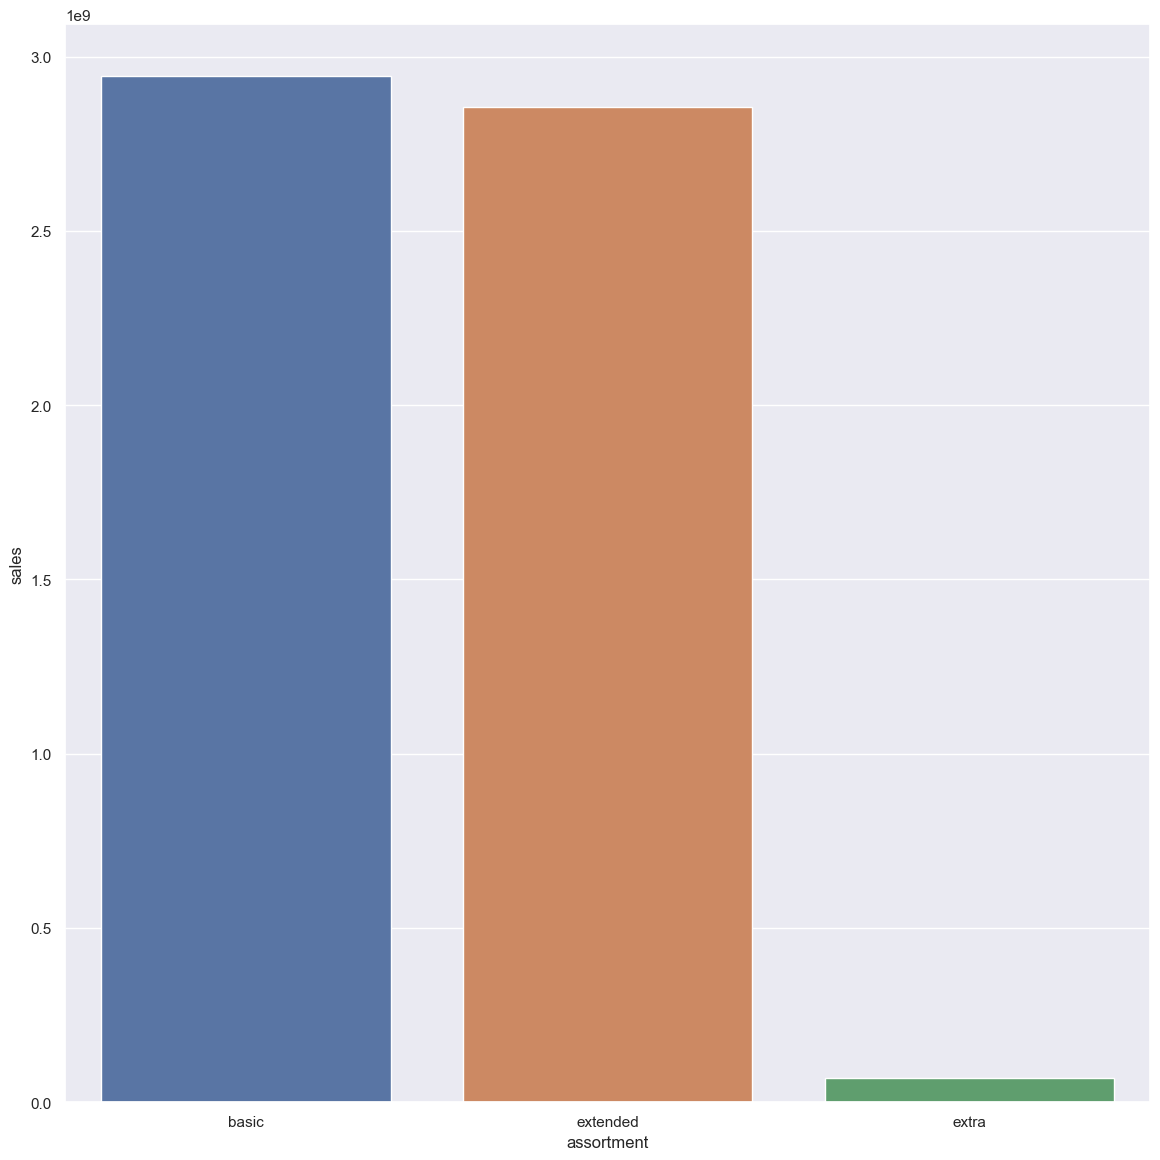

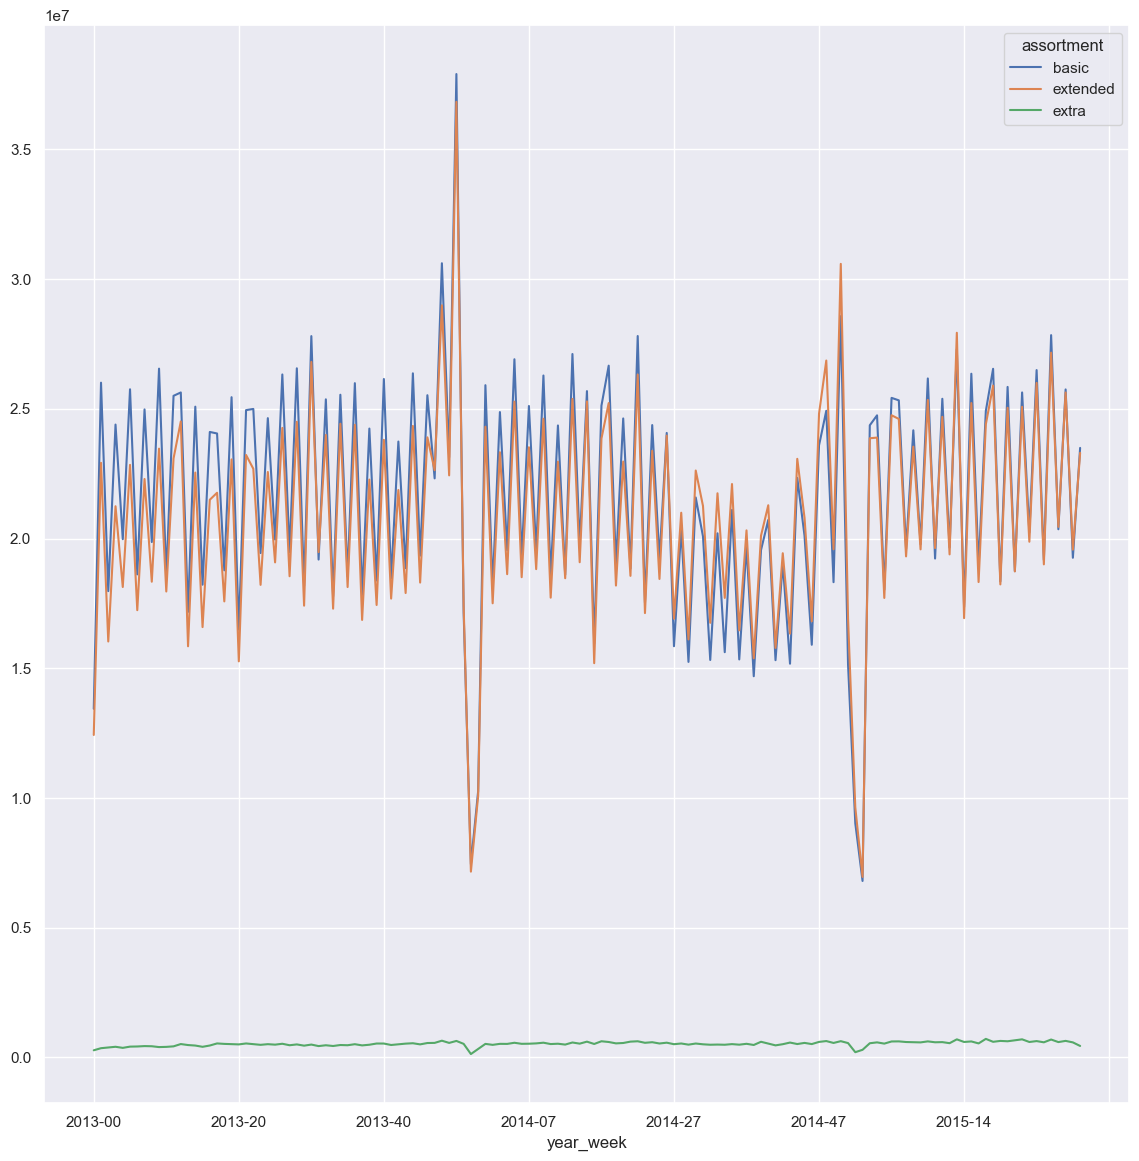

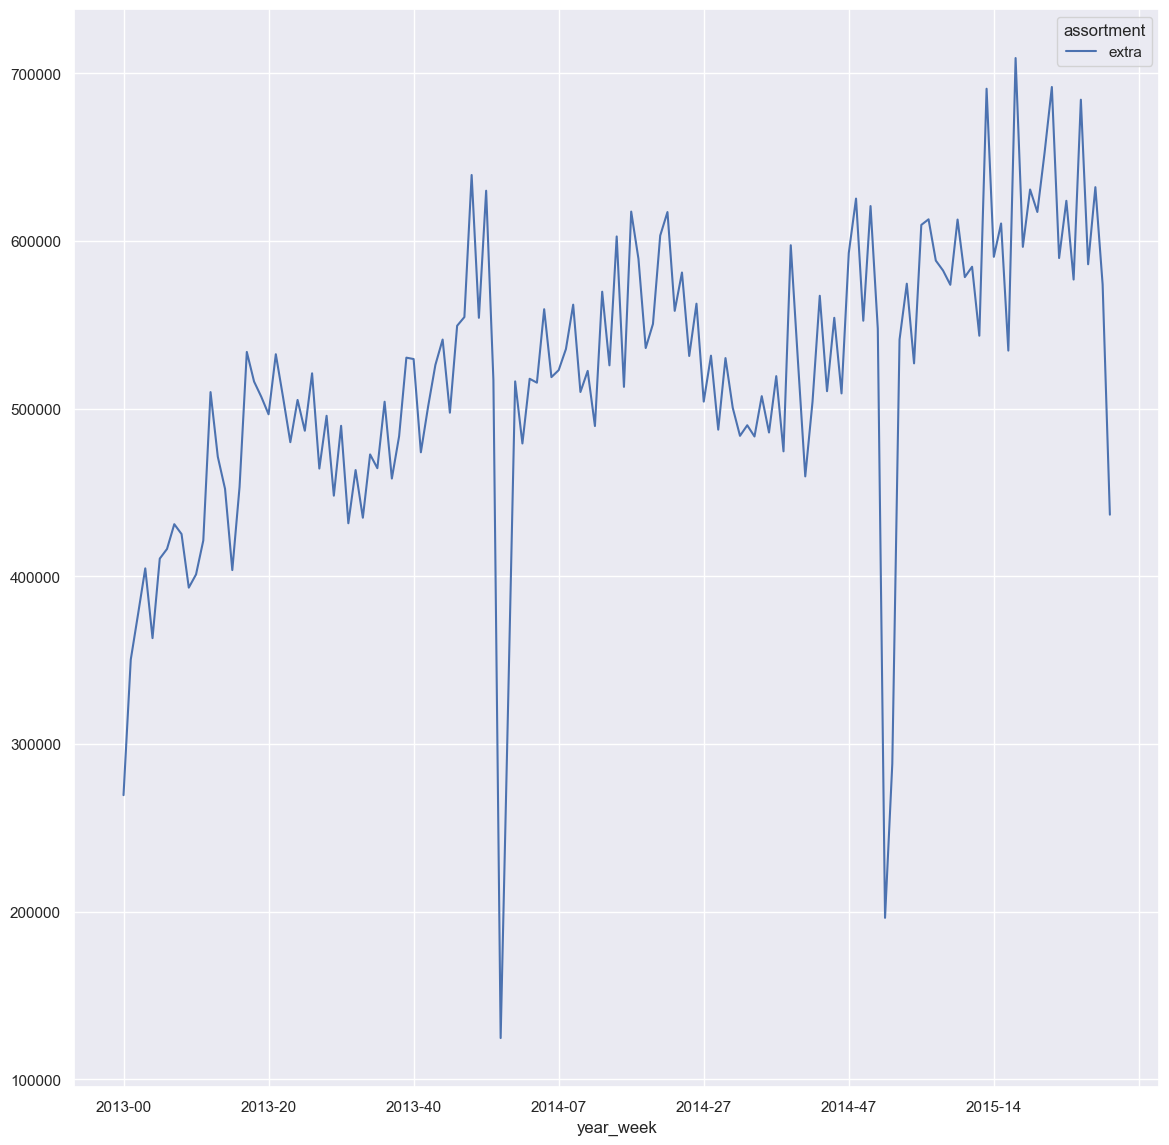

In [93]:

total_agrupado = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=total_agrupado);

total_agrupado_year_week = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
total_agrupado_year_week.pivot(index='year_week', columns='assortment', values='sales').plot();

total_agrupado_year_week_extra = total_agrupado_year_week[total_agrupado_year_week['assortment'] == 'extra']
total_agrupado_year_week_extra.pivot(index='year_week', columns='assortment', values='sales').plot();

### **2º Hipótese** Lojas com competidores mais proximos deveriam vender menos.

Logo na primeira visualização grafica podemos verificar que a Hipótese de Lojas com competidores mais proximo deveriam vender menos, se torna falsa, pois como é mostrado no grafico, lojas com competidores mais proximos venderam mais do que lojas com competidores mais distantes.



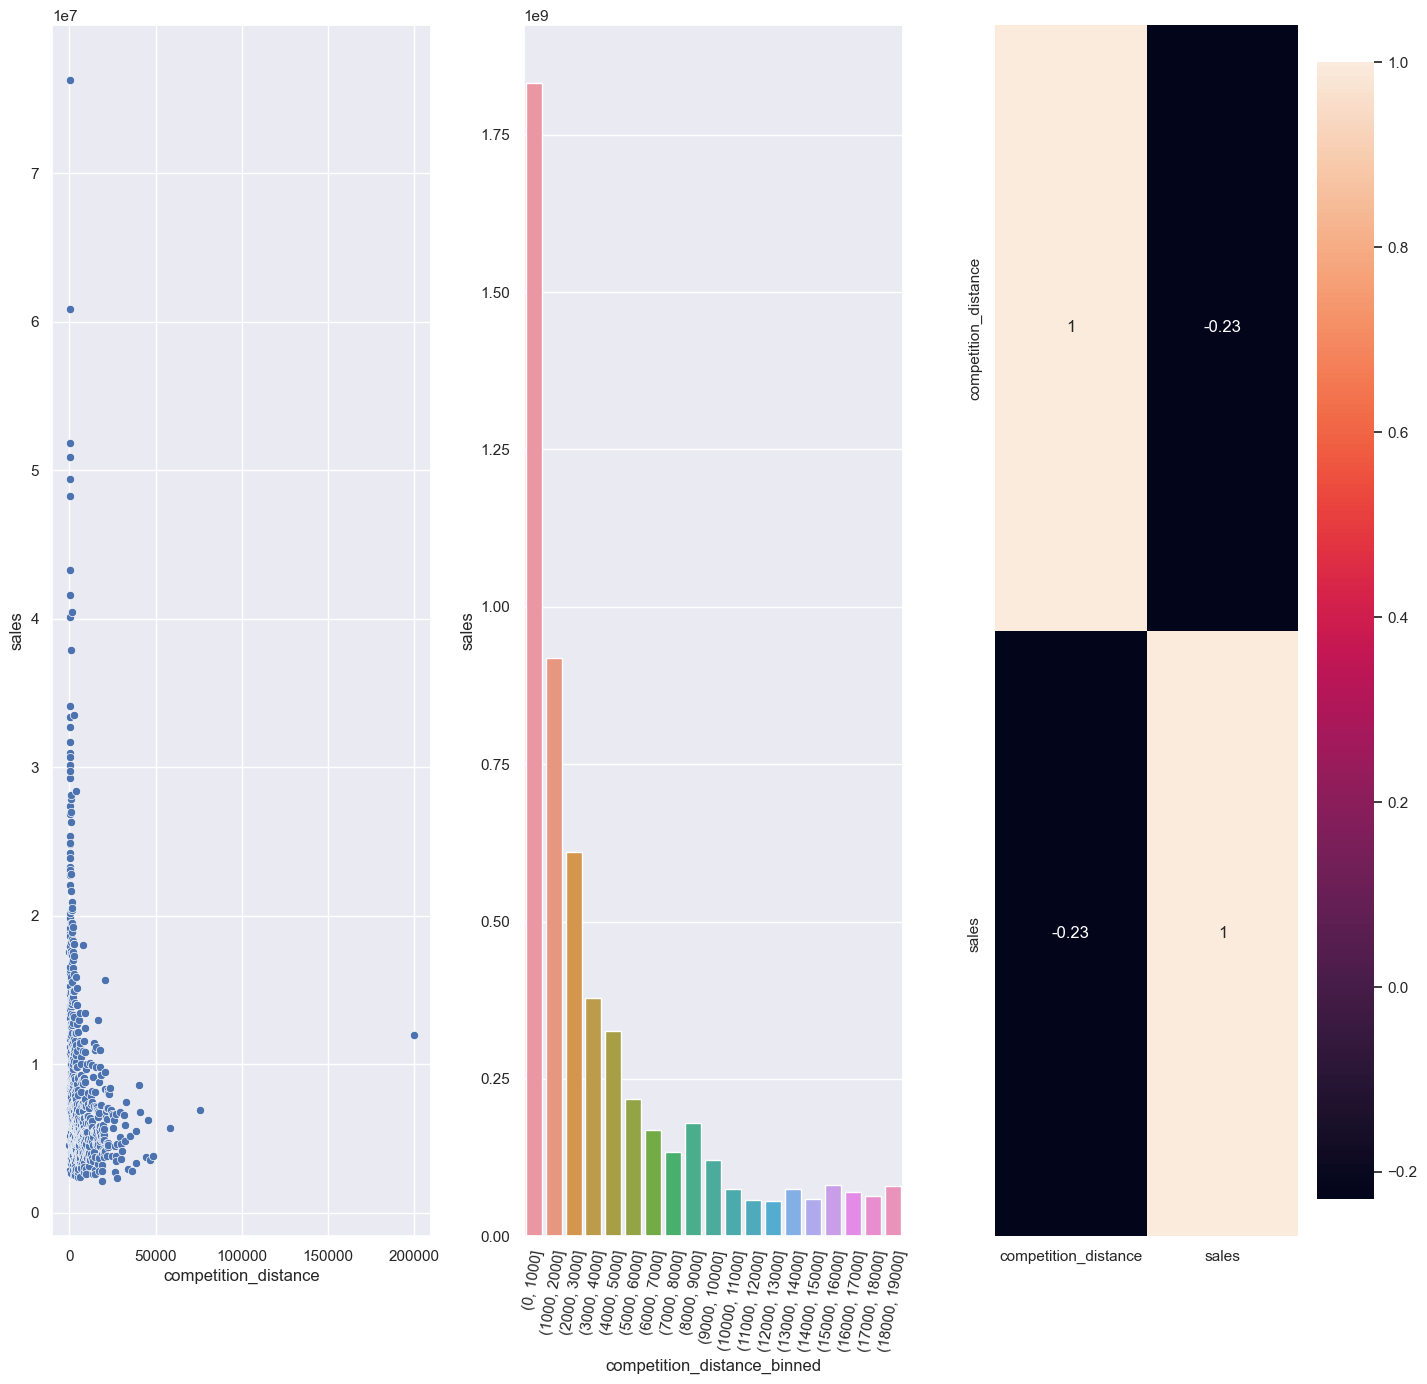

In [119]:

total_competition_distance = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()


plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=total_competition_distance);


# Grafico de Barras mostrando comportamento de vendas por competidores.
plt.subplot(1,3,2)
total_competition_distance_bin = total_competition_distance
total_competition_distance_bin['competition_distance_binned']  = pd.cut(total_competition_distance['competition_distance'], bins=list(np.arange(0, 20000, 1000)))
total_competition_distance_bin = total_competition_distance_bin[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=total_competition_distance_bin);
plt.xticks(rotation=80)
plt.tight_layout()

plt.subplot(1,3,3)
sns.heatmap(total_competition_distance.corr(method='pearson'), annot=True);




**3º Hipótese** Lojas com competidores à mais tempo deveriam vender mais.

## 4.3 Análise Multivariada